# VAD-Guided Transcription Benchmark

Test the fixed VAD (Voice Activity Detection) guided transcription approach.

**Key Fix**: Concatenate all speech regions into ONE array and transcribe once,
instead of processing each region separately (which caused massive overhead).

In [3]:
import time
import gc
import numpy as np
from pathlib import Path

from whisper_mlx import LightningWhisperMLX, VADProcessor
from whisper_mlx.audio import load_audio, SAMPLE_RATE

print("Imports loaded!")

Imports loaded!


In [4]:
# Find and load video file
data_dir = Path("data")
video_files = list(data_dir.glob("*.mp4")) + list(data_dir.glob("*.mp3"))

print(f"Found {len(video_files)} files:")
for i, f in enumerate(video_files):
    print(f"  {i}: {f}")
# Select video (change index as needed)
video_path = video_files[1] if video_files else None
print(f"\nUsing: {video_path}")

Found 2 files:
  0: data/test3.mp4
  1: data/test2.mp4

Using: data/test2.mp4


In [5]:
# Load audio
audio_data = load_audio(str(video_path))
audio_duration = len(audio_data) / SAMPLE_RATE

# Convert to numpy
if hasattr(audio_data, 'tolist'):
    audio_np = np.array(audio_data.tolist())
else:
    audio_np = np.array(audio_data)

print(f"Audio duration: {audio_duration:.2f} seconds")
print(f"Sample rate: {SAMPLE_RATE} Hz")
print(f"Audio shape: {audio_np.shape}")

Audio duration: 1804.07 seconds
Sample rate: 16000 Hz
Audio shape: (28865190,)


## VAD Analysis

Detect speech regions and calculate how much silence can be skipped.

In [6]:
# Detect speech regions
vad = VADProcessor(energy_threshold=0.02, min_speech_duration=0.3)
speech_regions = vad.detect_speech_regions(audio_np, SAMPLE_RATE)
skip_ratio = vad.get_skip_ratio(audio_np, SAMPLE_RATE)

print(f"Speech regions found: {len(speech_regions)}")
print(f"Silence that can be skipped: {skip_ratio*100:.1f}%")
print(f"\nSpeech regions (first 10):")
for i, (start, end) in enumerate(speech_regions[:10]):
    print(f"  {i+1}. {start/SAMPLE_RATE:.2f}s - {end/SAMPLE_RATE:.2f}s ({(end-start)/SAMPLE_RATE:.2f}s)")
if len(speech_regions) > 10:
    print(f"  ... and {len(speech_regions) - 10} more regions")

Speech regions found: 1767
Silence that can be skipped: 41.3%

Speech regions (first 10):
  1. 0.03s - 2.12s (2.08s)
  2. 2.46s - 4.08s (1.62s)
  3. 4.39s - 5.14s (0.76s)
  4. 5.43s - 6.33s (0.90s)
  5. 7.01s - 7.38s (0.38s)
  6. 7.56s - 7.92s (0.35s)
  7. 8.00s - 8.53s (0.53s)
  8. 8.85s - 9.52s (0.67s)
  9. 9.89s - 10.41s (0.53s)
  10. 10.53s - 10.86s (0.33s)
  ... and 1757 more regions


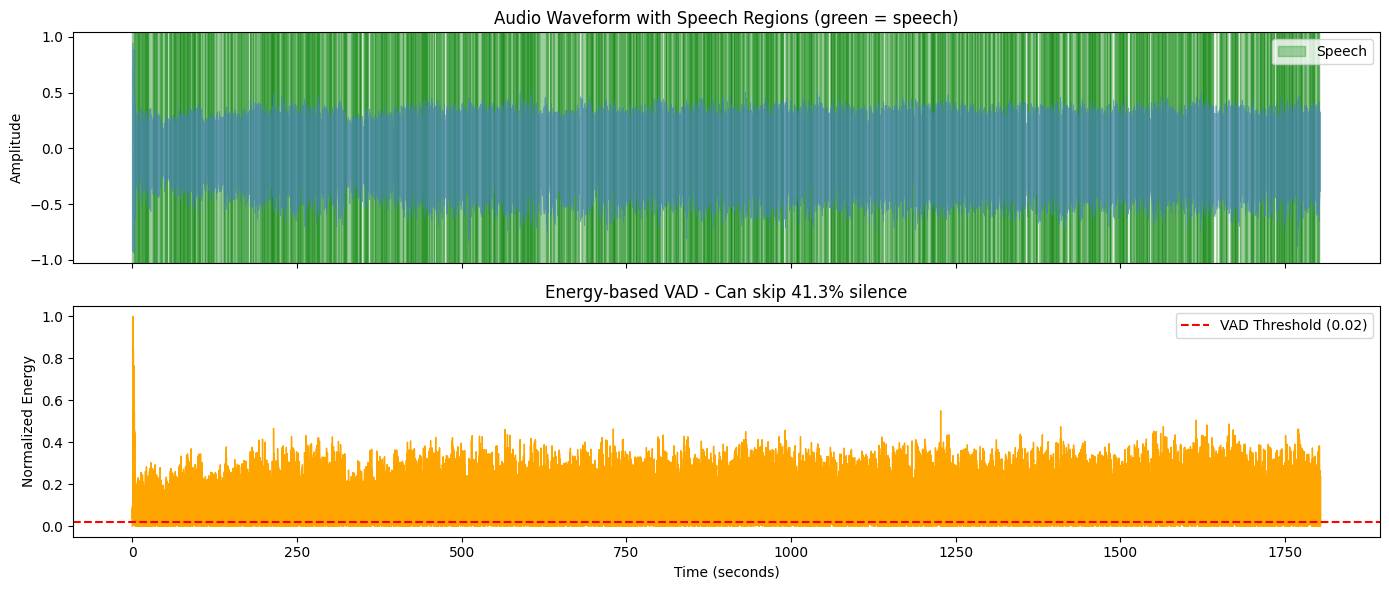

In [7]:
# Visualize VAD
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Waveform
time_axis = np.arange(len(audio_np)) / SAMPLE_RATE
axes[0].plot(time_axis, audio_np, color='steelblue', alpha=0.7, linewidth=0.5)
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Audio Waveform with Speech Regions (green = speech)')

# Highlight speech regions
for i, (start, end) in enumerate(speech_regions):
    label = 'Speech' if i == 0 else None
    axes[0].axvspan(start/SAMPLE_RATE, end/SAMPLE_RATE, alpha=0.3, color='green', label=label)
axes[0].legend(loc='upper right')

# Energy plot
frame_size = int(0.025 * SAMPLE_RATE)
hop_size = int(0.010 * SAMPLE_RATE)
num_frames = (len(audio_np) - frame_size) // hop_size + 1
energy = np.array([np.sqrt(np.mean(audio_np[i*hop_size:i*hop_size+frame_size]**2)) 
                   for i in range(num_frames)])
energy = energy / (np.max(energy) + 1e-8)
energy_time = np.arange(num_frames) * hop_size / SAMPLE_RATE

axes[1].plot(energy_time, energy, color='orange', linewidth=1)
axes[1].axhline(y=0.02, color='red', linestyle='--', label='VAD Threshold (0.02)')
axes[1].set_ylabel('Normalized Energy')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_title(f'Energy-based VAD - Can skip {skip_ratio*100:.1f}% silence')
axes[1].legend()

plt.tight_layout()
plt.show()

## Benchmark: Standard vs VAD-Guided

Compare the fixed VAD-Guided approach against standard batched transcription.

In [8]:
# Method 1: Standard Batched (baseline)
print("=" * 60)
print("METHOD 1: STANDARD BATCHED (batch_size=12)")
print("=" * 60)

whisper_std = LightningWhisperMLX(model="distil-large-v3", batch_size=12)
start = time.time()
result_std = whisper_std.transcribe(str(video_path), language="en", verbose=False)
time_std = time.time() - start
speed_std = audio_duration / time_std

print(f"Time: {time_std:.2f}s")
print(f"Speed: {speed_std:.1f}x realtime")
print(f"Audio processed: {audio_duration:.2f}s")

del whisper_std
gc.collect()

METHOD 1: STANDARD BATCHED (batch_size=12)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 180407/180407 [00:25<00:00, 7118.08frames/s]

Time: 28.34s
Speed: 63.7x realtime
Audio processed: 1804.07s


0

In [9]:
# Method 2: VAD-Guided (FIXED - concatenate all speech)
print("=" * 60)
print("METHOD 2: VAD-GUIDED BATCHED (FIXED)")
print("=" * 60)

# Concatenate ALL speech regions into one array
speech_audio_parts = []
for region_start, region_end in speech_regions:
    speech_segment = audio_np[region_start:region_end]
    if len(speech_segment) >= SAMPLE_RATE * 0.3:  # Skip < 0.3s segments
        speech_audio_parts.append(speech_segment)

concatenated_speech = np.concatenate(speech_audio_parts)
speech_duration = len(concatenated_speech) / SAMPLE_RATE

print(f"Original audio: {audio_duration:.2f}s")
print(f"Speech only: {speech_duration:.2f}s")
print(f"Silence removed: {audio_duration - speech_duration:.2f}s ({skip_ratio*100:.1f}%)")
print()

# Transcribe concatenated speech in ONE call
whisper_vad = LightningWhisperMLX(model="distil-large-v3", batch_size=12)
start = time.time()
result_vad = whisper_vad.transcribe(concatenated_speech, language="en", verbose=False)
time_vad = time.time() - start

# Speed relative to original audio duration (the real speedup)
speed_vad = audio_duration / time_vad
# Speed relative to actual speech processed
speed_vad_actual = speech_duration / time_vad

print(f"Time: {time_vad:.2f}s")
print(f"Speed (vs original audio): {speed_vad:.1f}x realtime")
print(f"Speed (vs speech only): {speed_vad_actual:.1f}x realtime")

del whisper_vad
gc.collect()

METHOD 2: VAD-GUIDED BATCHED (FIXED)
Original audio: 1804.07s
Speech only: 1059.85s
Silence removed: 744.23s (41.3%)



100%|██████████| 105984/105984 [00:23<00:00, 4583.01frames/s]

Time: 23.16s
Speed (vs original audio): 77.9x realtime
Speed (vs speech only): 45.8x realtime


0

In [10]:
# Compare results
print("=" * 60)
print("COMPARISON SUMMARY")
print("=" * 60)
print(f"{'Method':<25} {'Time':<10} {'Speed':<15} {'Speedup':<10}")
print("-" * 60)
print(f"{'Standard Batched':<25} {time_std:<10.2f} {speed_std:<15.1f} {'1.00x (baseline)':<10}")
print(f"{'VAD-Guided Batched':<25} {time_vad:<10.2f} {speed_vad:<15.1f} {time_std/time_vad:<10.2f}x")
print("=" * 60)

if time_vad < time_std:
    print(f"\nVAD-Guided is {time_std/time_vad:.2f}x FASTER than standard!")
else:
    print(f"\nVAD-Guided is {time_vad/time_std:.2f}x slower (overhead exceeds silence savings)")

COMPARISON SUMMARY
Method                    Time       Speed           Speedup   
------------------------------------------------------------
Standard Batched          28.34      63.7            1.00x (baseline)
VAD-Guided Batched        23.16      77.9            1.22      x

VAD-Guided is 1.22x FASTER than standard!


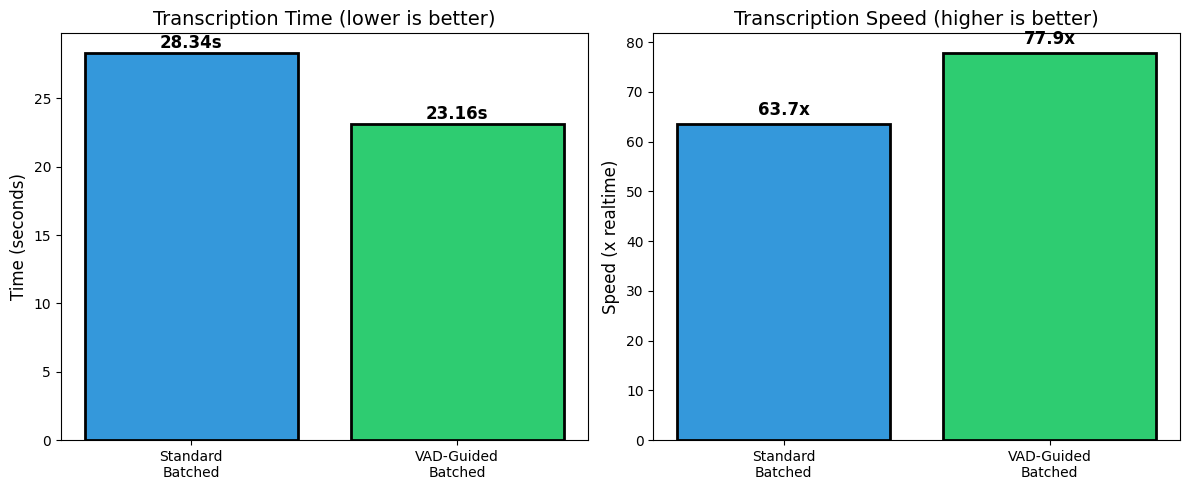

In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

methods = ['Standard\nBatched', 'VAD-Guided\nBatched']
times = [time_std, time_vad]
speeds = [speed_std, speed_vad]
colors = ['#3498db', '#2ecc71']

# Time comparison
bars1 = axes[0].bar(methods, times, color=colors, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Time (seconds)', fontsize=12)
axes[0].set_title('Transcription Time (lower is better)', fontsize=14)
for bar, val in zip(bars1, times):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.2f}s', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Speed comparison
bars2 = axes[1].bar(methods, speeds, color=colors, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Speed (x realtime)', fontsize=12)
axes[1].set_title('Transcription Speed (higher is better)', fontsize=14)
for bar, val in zip(bars2, speeds):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}x', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('vad_benchmark_results.png', dpi=150, bbox_inches='tight')
plt.show()

## Transcription Quality Comparison

In [12]:
print("=" * 60)
print("STANDARD BATCHED OUTPUT:")
print("=" * 60)
print(result_std['text'])

STANDARD BATCHED OUTPUT:
 What if you can see what's actually working on YouTube right now before everybody else, backed by data? One of the largest studies of 50,000 YouTube channels was conducted and it actually revealed 12 new shifts that are driving YouTube growth right now. This is an opinion. They actually spent $10,000 on this study and your cost is $0.00. I've got this broken down into the 12 insights based on questions. And this is one of the biggest questions that comes in all the time, right? What is the best video length on YouTube right now? Well, there's actually an answer based off real data. So check this out. The ideal video length, if your videos are going to be under an hour, is between 16 and 26 minutes. The actual range in the study is for videos under an hour. The sweet spot is 15 to 25 minutes for your videos. And they revealed that the danger. zone is 30 to 60 minutes. Now, how does this data show up? Well, there's a lot of information on the page here, but righ

In [13]:
print("=" * 60)
print("VAD-GUIDED OUTPUT:")
print("=" * 60)
print(result_vad['text'])

VAD-GUIDED OUTPUT:
 What if you could see what's actually working on YouTube right now before everybody else by data? One of the largest studies of 1,000 new channels was, and it actually revealed 12 news shift that are driving you right now. Inion, they actually $1,000 on this study and your $0.00. And this is one of the biggest comes in all the time, right? Best video length on YouTube right now. Well, there's actually an anthreal data. The ideal video length, your videos are going to be under our 15 and the actual range in the study videos under an hour, the 16, five minutes for your videos. And they revealed the danger zone 30 minutes. Now, how does data show? There's a lot of information on the page here, but right there, you see the danger zone. Shout out to Gun 1 with Tom Cruise, kind of your videos between 30 minute, one hour. And withinating, though, to longer videos, like 150 minute, 180 minute long, then they really over-indect view. Fascinating. And that's because longer vi

In [14]:
# Text similarity
def jaccard_similarity(text1, text2):
    words1 = set(text1.lower().split())
    words2 = set(text2.lower().split())
    if not words1 or not words2:
        return 0
    return len(words1 & words2) / len(words1 | words2)

similarity = jaccard_similarity(result_std['text'], result_vad['text'])
print(f"\nText similarity (Jaccard): {similarity*100:.1f}%")
print("\nNote: VAD removes silence between speech regions, which may affect")
print("word boundaries and cause some differences in transcription.")


Text similarity (Jaccard): 51.6%

Note: VAD removes silence between speech regions, which may affect
word boundaries and cause some differences in transcription.


## Conclusion

The **fixed VAD-Guided approach** concatenates all speech regions into one array
and processes them in a single `transcribe()` call.

**When VAD helps:**
- Audio with significant silence (podcasts, interviews, lectures)
- Long recordings with gaps between speakers

**When VAD may not help:**
- Continuous speech with little silence
- Short audio files (overhead may exceed savings)
- Audio where the VAD threshold misses speech